### See ProcessLandCover script

In [10]:
catchment_name  = 'WykeBeck'

In [11]:
import sys
import os
import folium
import numpy.ma as ma
from folium import Map, FeatureGroup, LayerControl
import rasterio
from shapely.geometry import box
import geopandas as gpd
from pyproj import CRS
from rasterio.mask import mask
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import contextily as cx
import matplotlib.patches as mpatches
import rioxarray as rxr
from rasterio import plot
from shapely.geometry import mapping
import glob 

# Define whether to filter out values <0.1
remove_little_values = True

sys.path.append("../ProcessModelResults/")
from my_functions import *

model_directory = '../../../FloodModelling/{}Models/'.format(catchment_name)

In [12]:
if catchment_name == 'LinDyke':
    catchment_gdf = gpd.read_file(model_directory + 'Model_IdealisedProfiles/CatchmentLinDyke_exported.shp'.format(catchment_name))
elif catchment_name == 'WykeBeck':
    catchment_gdf = gpd.read_file(model_directory + 'Model_IdealisedProfiles/WykeBeckCatchment.shp'.format(catchment_name))
    
# Add to dictionary    
boundaries_gpd_dict={}
boundaries_gpd_dict[catchment_name] =catchment_gdf

### Plot - both original landcover data and classified urban/not urban data

In [13]:
cols_dict = {}
cols = ['black','green', 'orange','purple','yellow','blue','cyan','pink', 'darkgreen']
for num,key in enumerate(boundaries_gpd_dict.keys()):
    cols_dict[key] =cols[num]

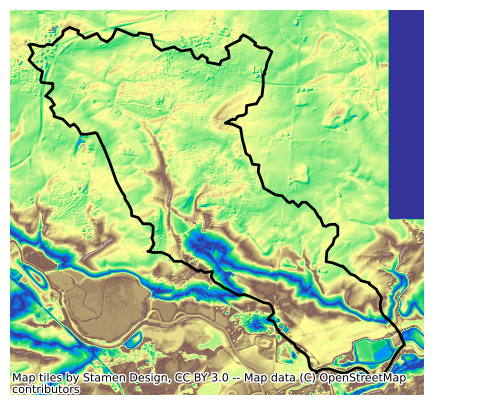

In [19]:
fig, ax=plt.subplots(figsize=(14,5))
# clipped = rasterio.open(model_directory + 'Model_FEHProfiles/Terrain/Terrain.wykeDEM.tif')
clipped = rasterio.open(model_directory + 'TerrainData/terrain.tif')

for boundary_key, boundary in boundaries_gpd_dict.items():
    boundary.plot(ax=ax, facecolor="none", linewidth=2, edgecolor =cols_dict[boundary_key])
cx.add_basemap(ax, crs = catchment_gdf.crs.to_string(), url = cx.providers.OpenStreetMap.Mapnik)
image = plot.show((clipped, 1), ax= ax, cmap=plt.cm.terrain);
ax.axis('off');

### Find average elevation in each catchment
(we need this for filtering the ..)

In [110]:
main_df=pd.DataFrame()
raster = rxr.open_rasterio('../../../../FloodModelling/TerrainData/terrain.tif', masked=True).squeeze()
for region_name in ['LinDyke', 'Kippax', 'Garforth', 'Kippax_West', 'Garforth_East', 'Garforth_West', 'South_Catchment', 
                    'TB_South', 'TB_North']:
    # Get region boundary
    region_boundary = boundaries_gpd_dict[region_name]
        
    # Trim terrain data
    raster_clipped = raster.rio.clip(region_boundary.geometry.apply(mapping),region_boundary.crs)
    
    # Add to 
    df= pd.DataFrame({'mean1':np.nanmean(raster_clipped[1].data), "max1":np.nanmax(raster_clipped[1].data), 
                      'min1':np.nanmin(raster_clipped[1].data)}, index=[region_name])
    main_df=pd.concat([df, main_df],axis=0)

In [111]:
main_df.sort_values(by='mean1', ascending=False)

,mean1,max1,min1
TB_South,112.538940,204.0,0.0
Garforth,83.534760,179.0,0.0
Garforth_East,83.114998,171.0,0.0
LinDyke,80.959839,249.0,0.0
Kippax,74.289078,211.0,0.0
Garforth_West,63.053520,175.0,0.0
Kippax_West,62.065681,160.0,0.0
South_Catchment,59.232822,182.0,0.0
TB_North,58.412056,146.0,0.0
